In [60]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter


import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
HEIGHT = 10
ASPECT = 1.8

In [61]:
df = pd.read_csv('../../raw_data/deliveries.csv')
df.head()

,index,order_id,order_value,order_items_count,customer_id,created_timestamp_local,has_instruction,logistics_dropoff_distance,delivery_postal_code,delivery_geohash_precision8,has_phone_number,has_call_instruction,has_leave_instruction,has_lift_instruction,has_lobby_instruction,has_gate_instruction,has_knock_instruction,has_bell_instruction
0,618,b8ds-tqhf,40.44,10,h6huq0td,2021-03-11T20:19:50,True,58.656138,828868,w23bh248,False,False,False,False,False,False,False,False
1,619,x5xx-j2d2,35.60,10,t2nod4rq,2021-03-12T18:42:48,True,39.025148,530548,w21zu55k,False,False,False,False,False,False,False,False
2,620,x6qu-14kt,42.49,12,m4ycd3tm,2021-03-27T11:29:17,True,40.067811,650248,w21z9jc4,False,False,True,False,False,False,False,False
3,621,x3yw-rhc5,14.40,11,sgmnf9sb,2021-03-02T22:08:52,True,44.986785,550105,w21zg97y,False,False,False,False,False,False,False,False
4,622,y9zp-58q7,38.15,10,x4rvv3iy,2021-03-23T20:35:26,True,71.520828,102112,w21z61q6,False,False,False,False,False,False,False,False


First thing to look at will be the number of variables and target variable  
We need to identify whether there are duplicate rows or missing values (only postal code has nan values)





In [62]:
#get total customer ids

total_customers = len(df['customer_id'].unique())
total_orders = len(df['order_id'].unique())

#Avg orders per customer = 
avg_orders = total_orders/total_customers
print(total_customers)
print(total_orders)
print(avg_orders)

565549
2593799
4.586338230639608


There are a total of 2.5 million orders and approximately 0.56 million unique customer ids. 
Let us observe the customers with few orders vs many orders. We'll select an arbitrary threshold of 5 orders


In [63]:
frequent = df.groupby('customer_id')[['order_id']].count().reset_index()
frequent = frequent[frequent['order_id'] >= 5]
frequent_orders = sum(frequent['order_id'])
print(len(frequent))
# print(sum(grouped['order_id']))

print("{0} customers contribute to {1} of orders".format(len(frequent), frequent_orders))

170233
170233 customers contribute to 1845725 of orders


In other words, 30.10% customers contribute to 65% of all orders  

Next, Order ID and Customer ID are just identifiers, hence order_id and customer_id cannot be used for training. customer_id can be used as a historical reference in case of several orders from that id, to determine an average dropoff distance.

#identify outliers
There are a few dropoff distances that go up to 1.5 million m which we need to eliminate. 

In [64]:
def determine_outliers(list_of_nums):
    p_val = []
    thresh = 2*np.mean(list_of_nums)
    for i in range(95,101,1):
        p = np.percentile(list_of_nums, i)
        p_val.append(p)
    return p_val
    
        
dropoffs = sorted(df['logistics_dropoff_distance'].tolist(), reverse=False)     
p_val = determine_outliers(dropoffs)
print(p_val)

[154.06490707527, 185.0475324617922, 239.27216832541404, 348.2484280898161, 698.9862677974243, 15328253.689635966]


It can be seen that the distance corresponding to 99 percentile is 698m whereas the last percentile goes up to 1.5million kms. Using a round figure of 1km (1000m) we can drop the outliers which constitute about 17430 orders

In [65]:
print(len(df))
df = df[df['logistics_dropoff_distance'] <= 1000]
print(len(df))

2593799
2576369


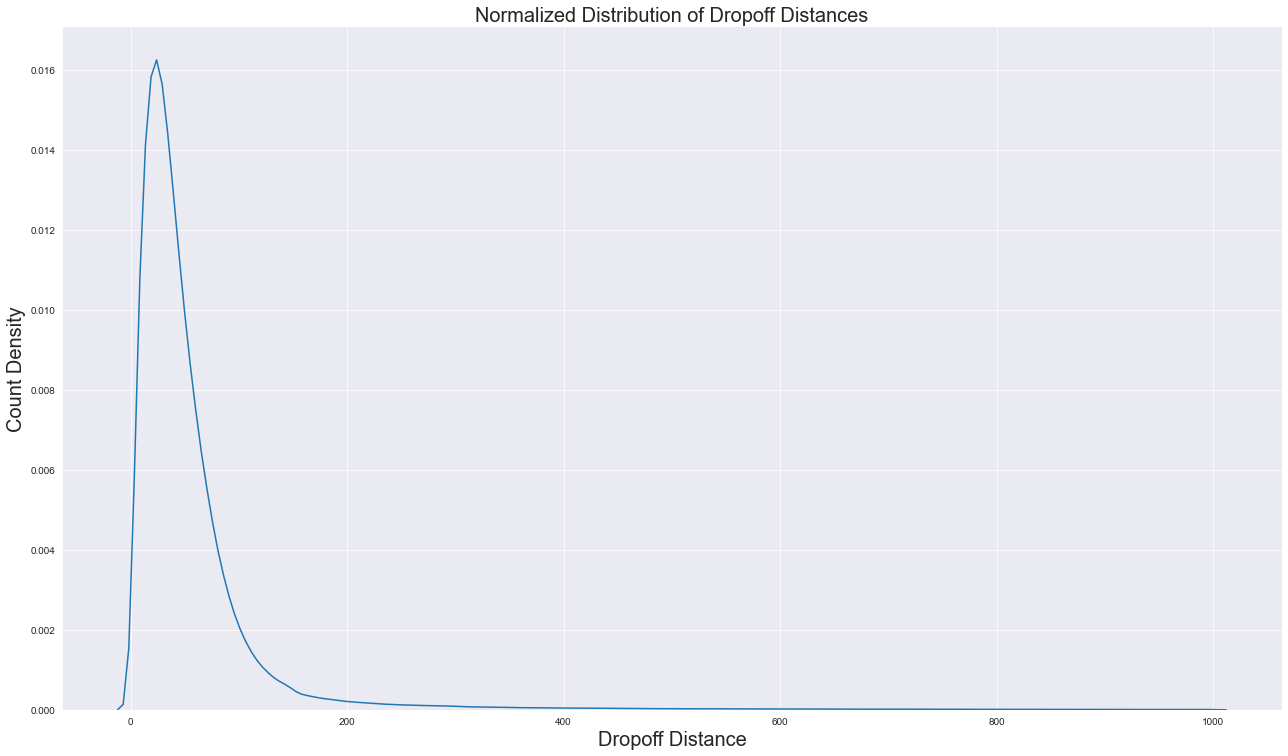

In [69]:
sns.set_style("darkgrid")
ax = sns.displot(df['logistics_dropoff_distance'].tolist(), height=HEIGHT, aspect=ASPECT, kind="kde")
ax.set(xlabel='Dropoff Distance', ylabel='Count Density', title = 'Normalized Distribution of Dropoff Distances')
plt.show()

97% of dropoff distances lie within 200m  
90% of dropoff distances lie within 100m  
50% of dropoff distances lie within 40m

# Identify relationships

Variables to consider:  
order_value  
order_items_count  
created_timestamp_local  
delivery_postal_code  
delivery_geohash_precision8  
has_instruction
has_phone_number  
has_call_instruction  
has_leave_instruction  
has_lift_instruction  
has_lobby_instruction  
has_gate_instruction  
has_knock_instruction  
has_bell_instruction

## order value


Since order value is a continuous variable, we'll use a scatterplot to understand its relation with the target variable. Also we check its value distribution using a histogram

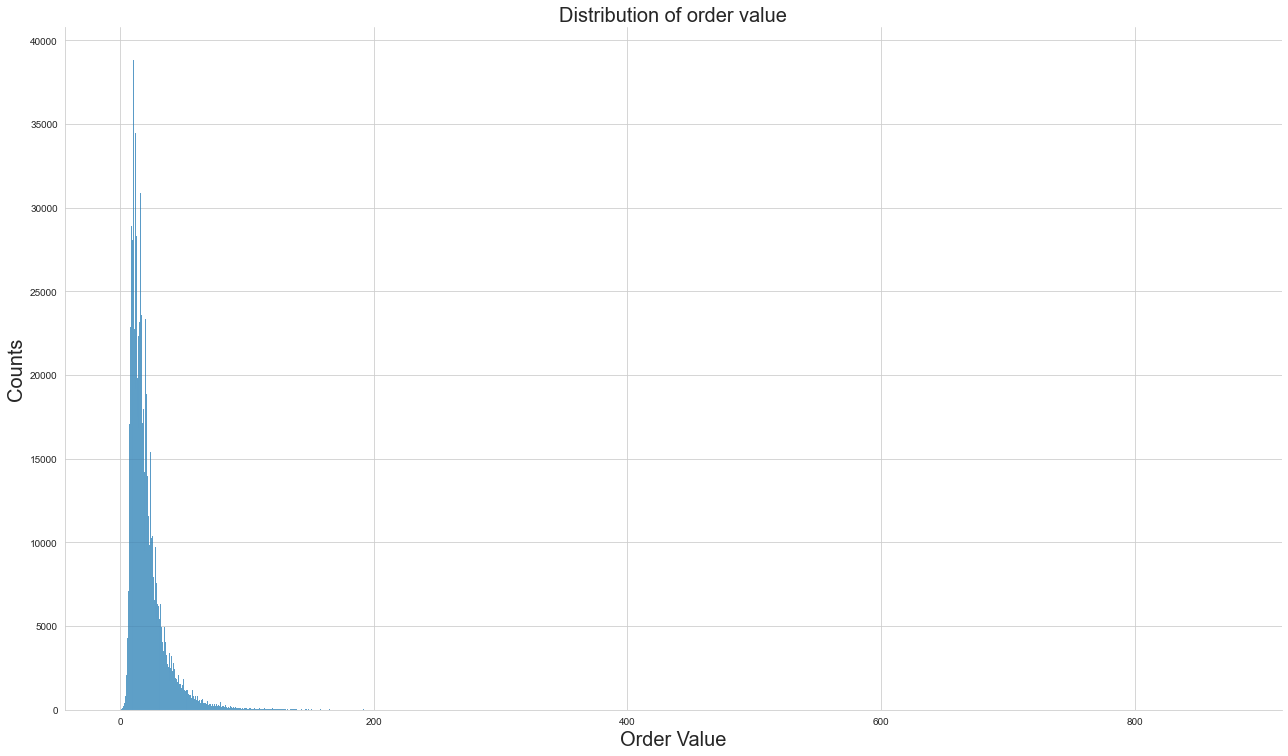

In [38]:
sns.set_style("whitegrid")
ax = sns.displot(df['order_value'].tolist(), height=HEIGHT, aspect=ASPECT)
ax.set(xlabel='Order Value', ylabel='Counts', title = 'Distribution of order value')
plt.show()

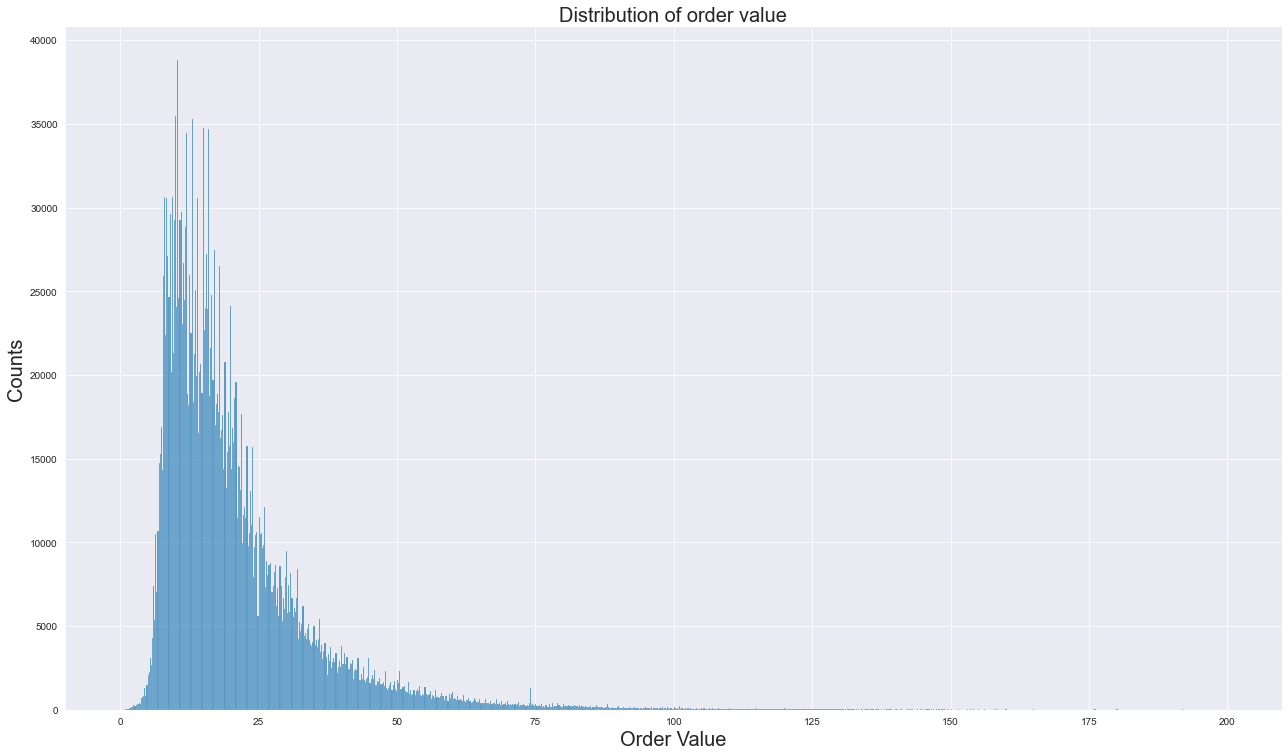

In [70]:
sns.set_style("darkgrid")
ax = sns.displot(df[df['order_value'] <200]['order_value'].tolist(), height=HEIGHT, aspect=ASPECT)
ax.set(xlabel='Order Value', ylabel='Counts', title = 'Distribution of order value')
plt.show()

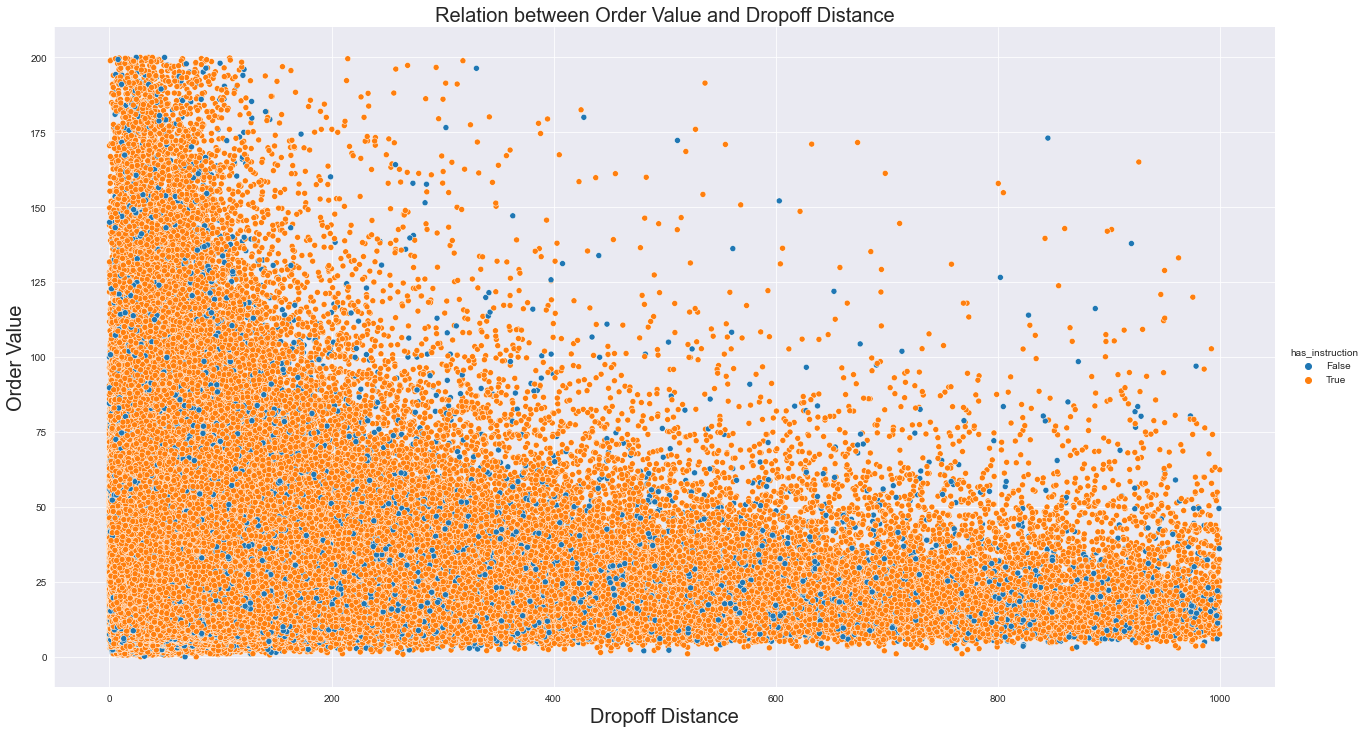

In [75]:
#to plot the relation, we subset order value below 200
subset = df[df['order_value']<=200]

ax = sns.relplot(x="logistics_dropoff_distance", y="order_value", data=subset, height=HEIGHT, aspect=ASPECT, hue='has_instruction')
ax.set(xlabel='Dropoff Distance', ylabel='Order Value', title = 'Relation between Order Value and Dropoff Distance')
plt.show()

## order items count

This is a continous variable so we do a similar thing

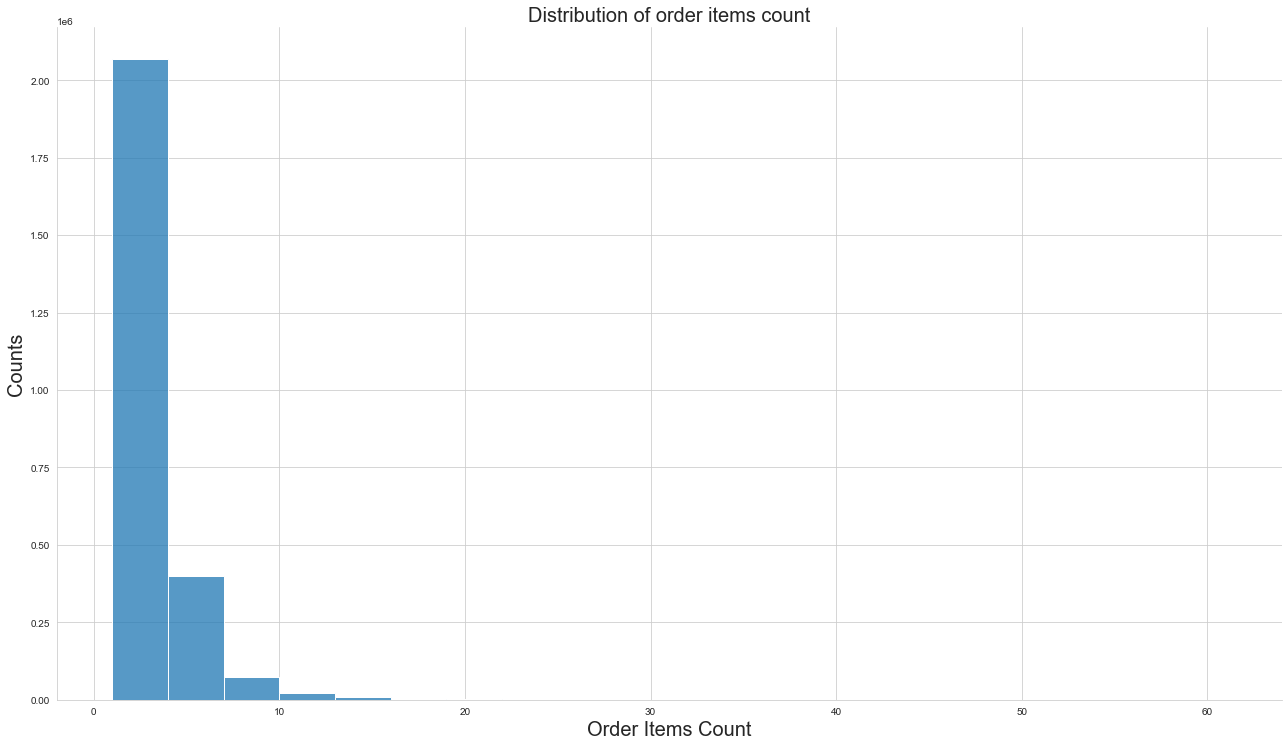

In [40]:
ax = sns.displot(df['order_items_count'].tolist(), binwidth=3, height=HEIGHT, aspect=ASPECT)
ax.set(xlabel='Order Items Count', ylabel='Counts', title = 'Distribution of order items count')
plt.show()

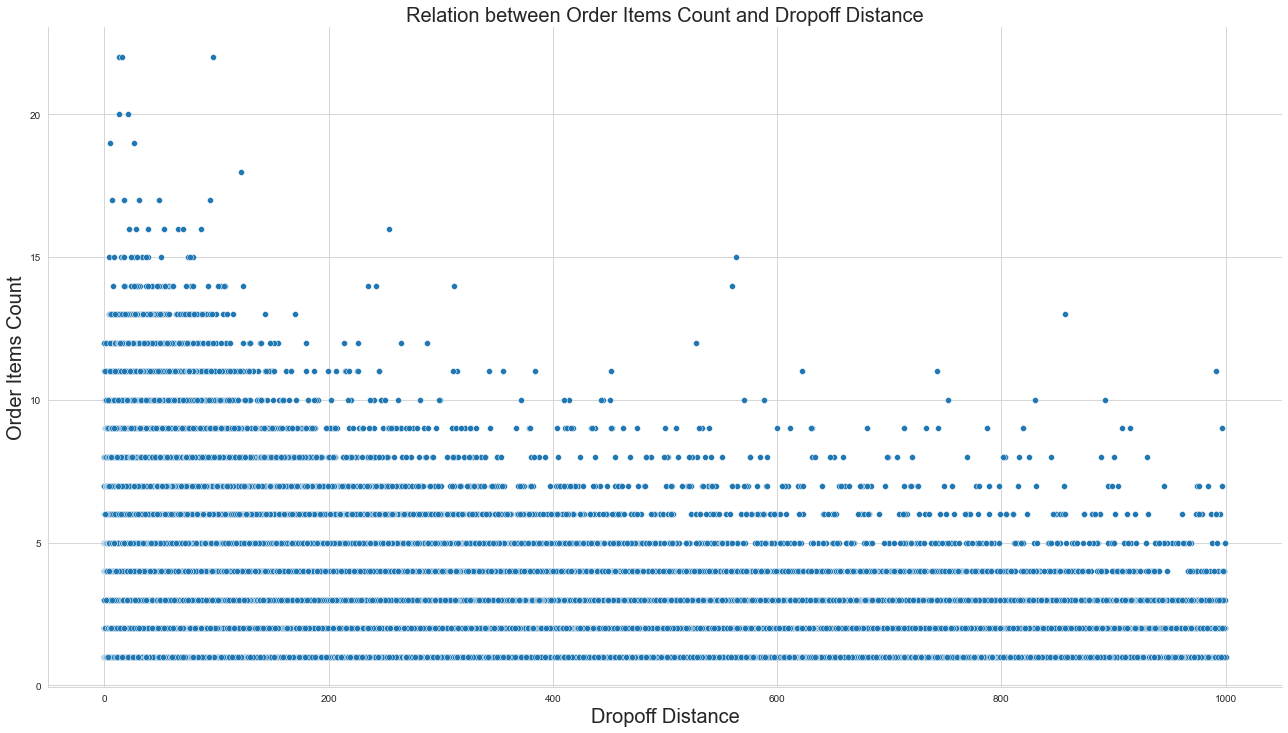

In [41]:
#to plot the relation, we subset order items count below 20
subset = df[df['order_value']<=20]

ax = sns.relplot(x="logistics_dropoff_distance", y="order_items_count", data=subset, height=HEIGHT, aspect=ASPECT)
ax.set(xlabel='Dropoff Distance', ylabel='Order Items Count', title = 'Relation between Order Items Count and Dropoff Distance')
plt.show()

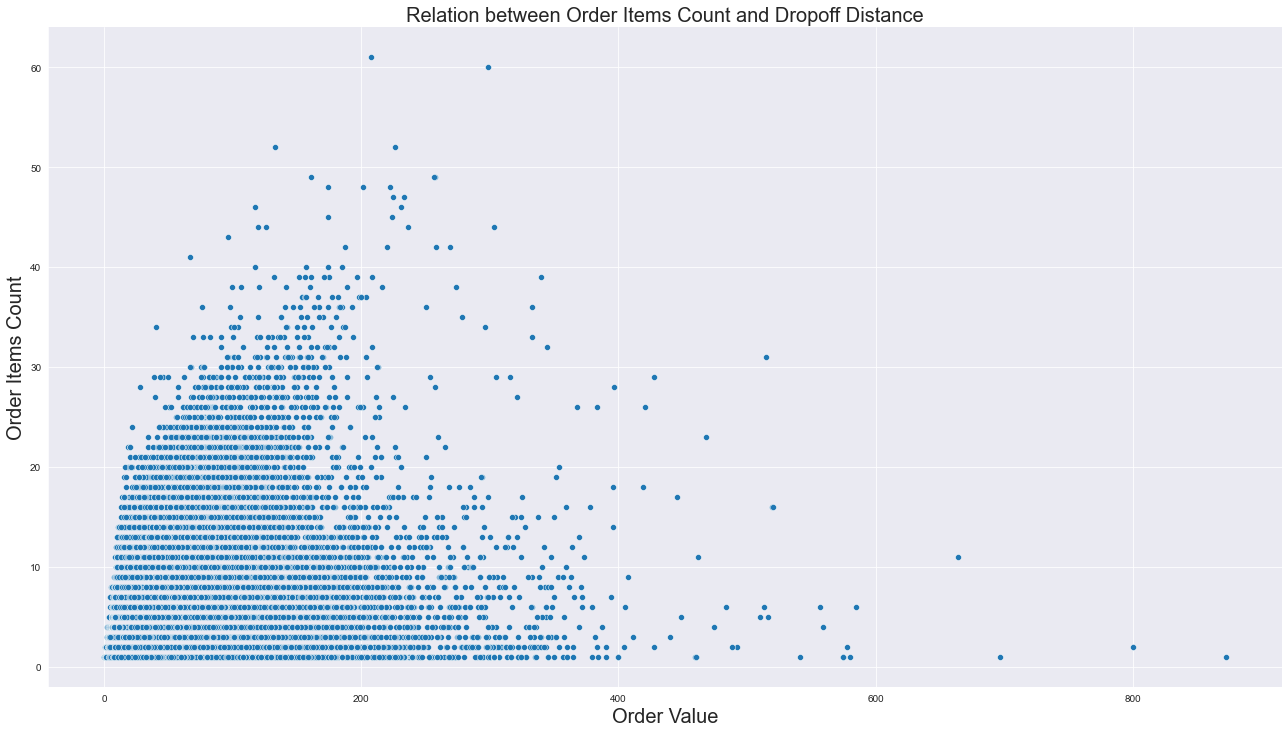

In [73]:
ax = sns.relplot(x="order_value", y="order_items_count", data=df, height=HEIGHT, aspect=ASPECT)
ax.set(xlabel='Order Value', ylabel='Order Items Count', title = 'Correlation between Order Items Count and Order Value')
plt.show()

**Continuous variable summary:**  
Order value and Items count both are significant features as mostly less items have a higher dropoff distance as well as lower order values

## created_timestamp_local

Though this variable can be used to determine dropoff distance or delivery time with either day of week, day of month or hour of day. We'll limit the analysis to hour of day

In [42]:
def extract_hour(field):
    return re.findall(r'T(.*?)\:', field, re.I)[0]

df['hour'] = df['created_timestamp_local'].apply(extract_hour)


In [43]:
subset = df[['hour', 'logistics_dropoff_distance']]
subset.sort_values(by='hour').reset_index(inplace=True)

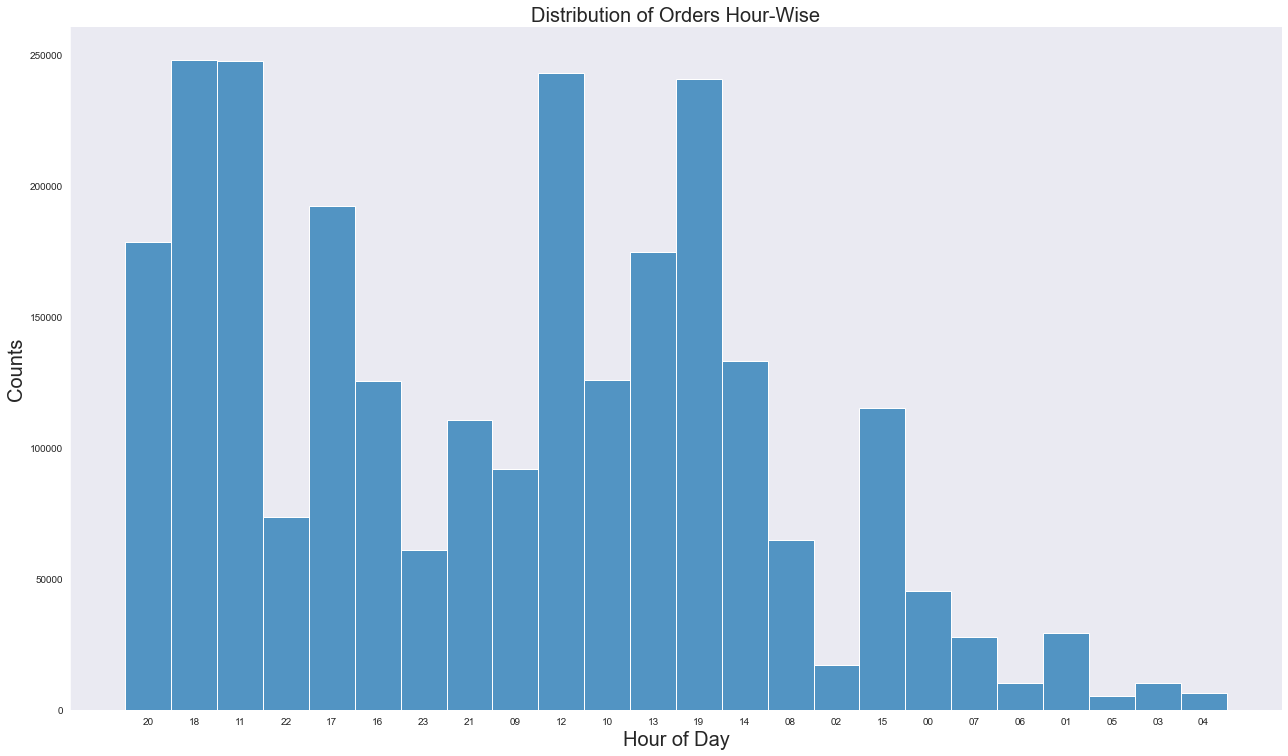

In [44]:
sns.set_style("dark")
ax = sns.displot(subset['hour'].tolist(), height=HEIGHT, aspect=ASPECT)
ax.set(xlabel='Hour of Day', ylabel='Counts', title = 'Distribution of Orders Hour-Wise')
plt.show()

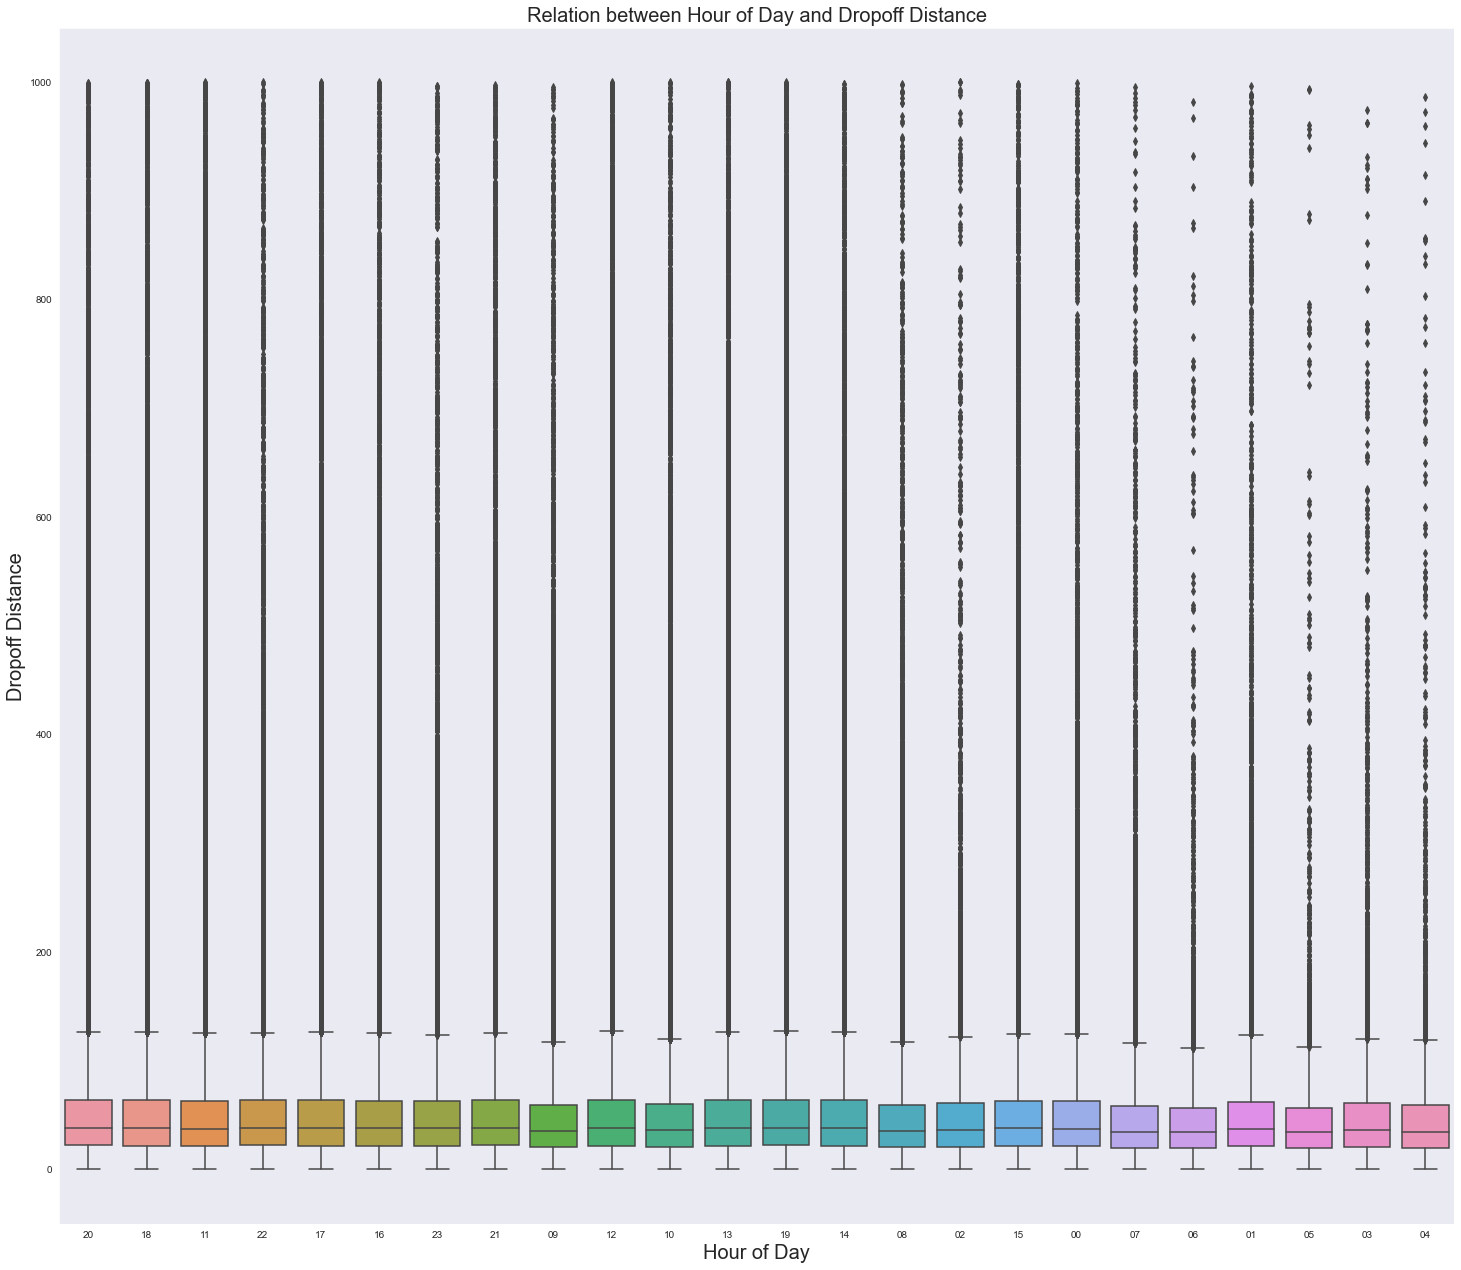

In [46]:
fig, ax = plt.subplots(figsize=(25,22))

ax = sns.boxplot(x="hour", y="logistics_dropoff_distance", data=subset)
ax.set(xlabel='Hour of Day', ylabel='Dropoff Distance', title = 'Relation between Hour of Day and Dropoff Distance')
plt.show()

## delivery_postal_code

In [19]:
codes_count = Counter(df['delivery_postal_code'].tolist())
filtered_dict = {k:v for (k,v) in codes_count.items() if v>35}
filtered_dict = {k:v for (k,v) in filtered_dict.items() if pd.notnull(v)}

postal_codes_to_plot = list(filtered_dict.keys())

There are too many postal codes to consider and for the sake of simplicity we will ignore this feature as a geohash will a better descriptor of areas than postal codes. 

## delivery_geohash_precision8

In [20]:
all_geohashes = pd.unique(df['delivery_geohash_precision8'].values)
print(len(all_geohashes))

119119


Assuming a larger geohas corresponds to a more precise location, there are too many values for it and  this might need to be handled to identify areas around the geography to see if any such area exhibits a statistically significant difference in terms of dropoff distance

In [21]:
subset = df[['delivery_geohash_precision8', 'logistics_dropoff_distance']]
for i in range(1,7):
    subset['delivery_geohash_precision{0}'.format(i)] = subset['delivery_geohash_precision8'].apply(lambda x: x[:i])  
    nth_geohash = pd.unique(subset['delivery_geohash_precision{0}'.format(i)].values)
    print("Characters considered : {0}".format(i))
    print(len(nth_geohash))

<ipython-input-21-b1ffd044badb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['delivery_geohash_precision{0}'.format(i)] = subset['delivery_geohash_precision8'].apply(lambda x: x[:i])


Characters considered : 1
1
Characters considered : 2
1
Characters considered : 3
2
Characters considered : 4
3
Characters considered : 5
37
Characters considered : 6
622


5 and 6 characters look interesting as they have sufficient amount of generalization. We'll plot all values for 5 as a start.

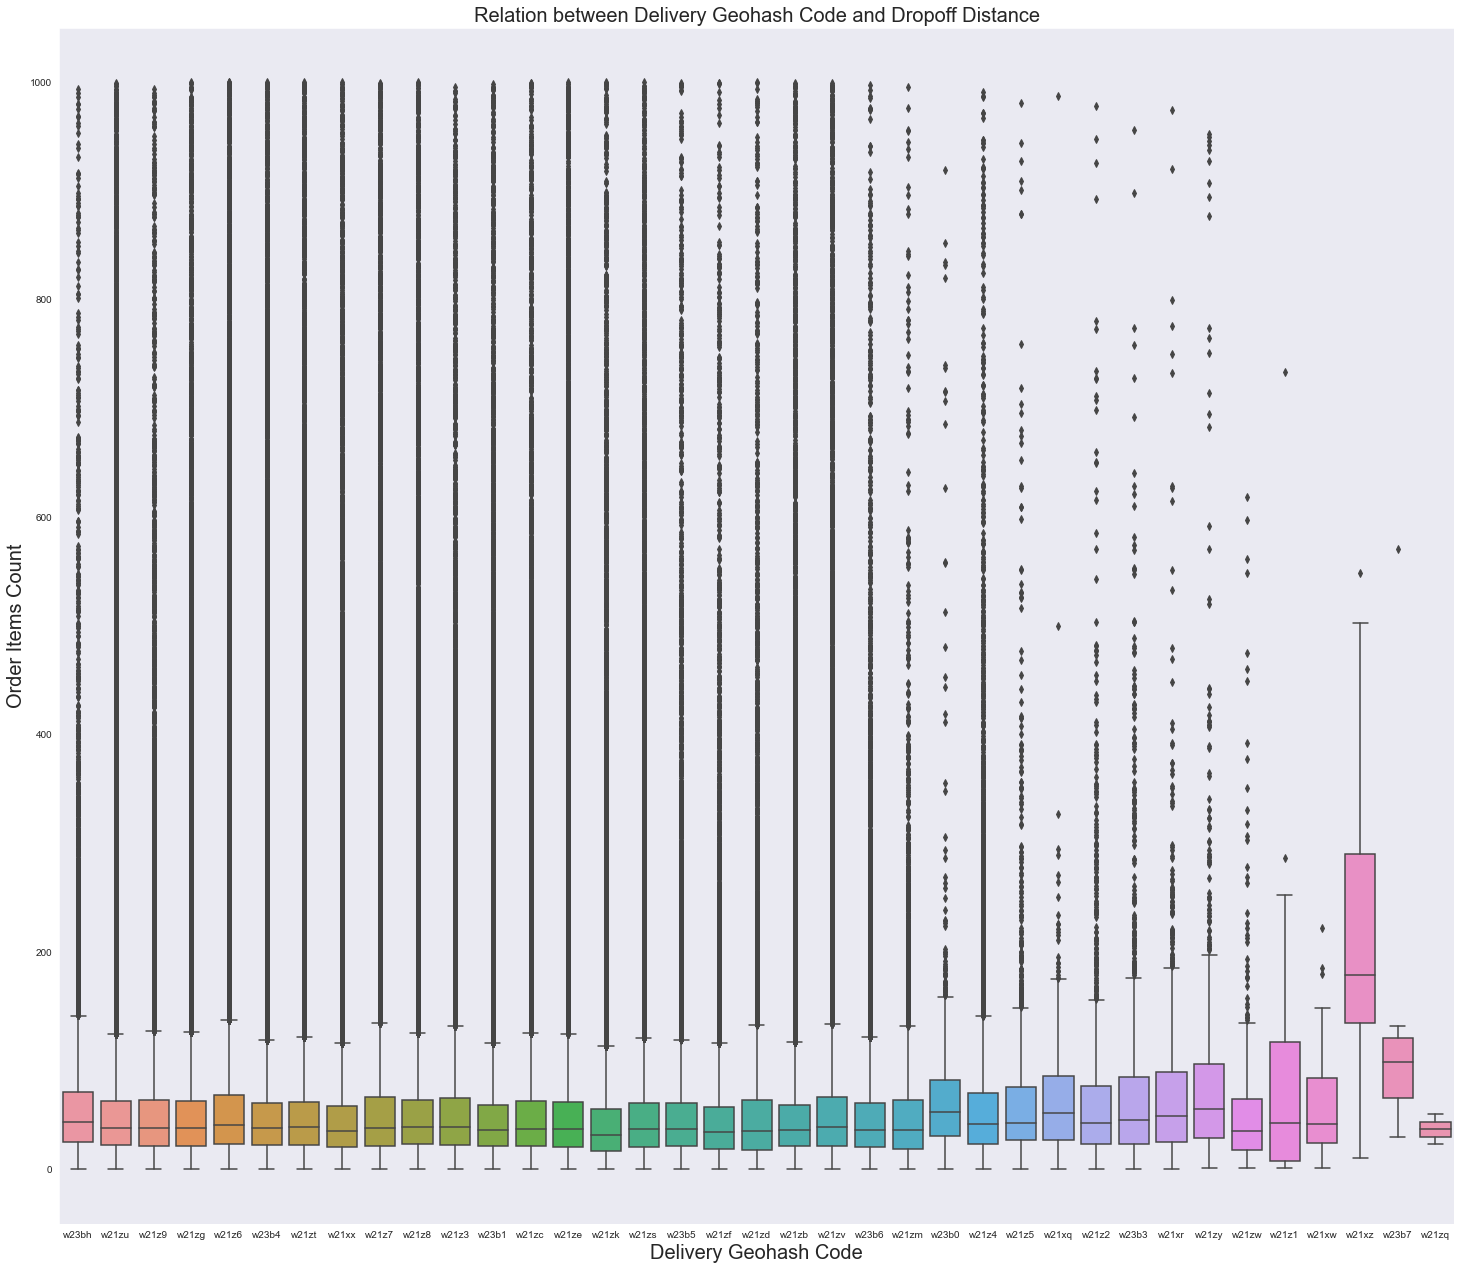

In [22]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(25,22))
ax = sns.boxplot(x="delivery_geohash_precision5", y="logistics_dropoff_distance", data=subset)
ax.set(xlabel='Delivery Geohash Code', ylabel='Order Items Count', title = 'Relation between Delivery Geohash Code and Dropoff Distance')
plt.show()

We'll ignore delivery_geohash_precision6 for now though it could be used as a useful feature for a higher variance in the model. We'll now see the geohash precision that can be used to identify a higher dropoff distance

In [139]:
nth_geohash = pd.unique(subset['delivery_geohash_precision5'].values)
for val in nth_geohash:
    smalldf = subset[subset['delivery_geohash_precision5'] == val]
    if np.median(smalldf['logistics_dropoff_distance'].tolist()) > 90:
        print(val)
        print(np.median(smalldf['logistics_dropoff_distance']))

w21xz
179.1146613511
w23b7
98.6846293729


we'll add a feature called "is_w21xz" to the original df with 1 where it is present and 0 where it isn't

In [142]:
df['is_w21xz'] = df['delivery_geohash_precision8'].apply(lambda z: z.startswith('w21xz'))
df['is_w23b7'] = df['delivery_geohash_precision8'].apply(lambda z: z.startswith('w23b7'))

print(len(df[df['is_w23b7']==True]))
print(len(df[df['is_w23b7']==False]))

11
2576358


These hardly cover about 50 cases and can be ignored in the model. The ideal way is to identify their clusters which have similar distributions and group them. That is a time consuming task and for simplicity, we simply ignore this feature.

## Instruction Fields

Since they're all binary we tackle them together

<ipython-input-204-cf92cc5f32c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['logistics_dropoff_distance'] = df['logistics_dropoff_distance']


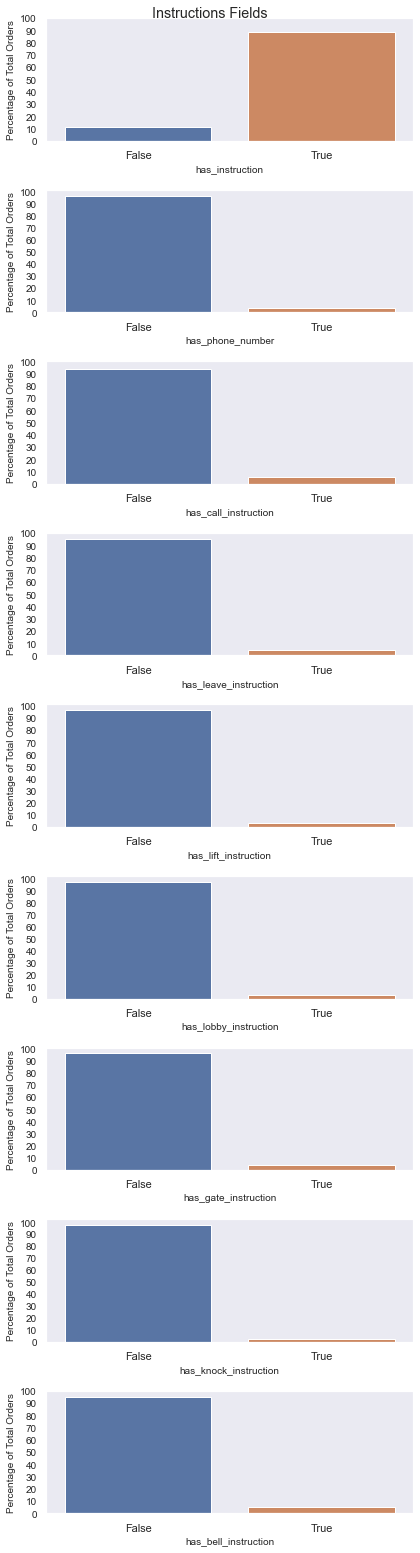

In [204]:
instruction_fields = ['has_instruction', 'has_phone_number',
'has_call_instruction',
'has_leave_instruction',
'has_lift_instruction',
'has_lobby_instruction',
'has_gate_instruction',
'has_knock_instruction',
'has_bell_instruction']

subset = pd.DataFrame()
subset = df[instruction_fields]
subset['logistics_dropoff_distance'] = df['logistics_dropoff_distance']

percent_count = lambda z: len(z)*100 / len(subset)

fig , axes = plt.subplots(9, 1, figsize=(6,22))
fig.suptitle('Instructions Fields')
for i,instruction in enumerate(instruction_fields):
    sns.barplot(x=instruction_fields[i], y=instruction_fields[i], data=subset, estimator=percent_count, ax=axes[i])
    axes[i].set_yticks(list(range(0,110,10)))
    axes[i].set_yticklabels([int(x) for x in axes[i].get_yticks()], fontsize=10)
    axes[i].set_xlabel(instruction_fields[i], fontsize =10)
    axes[i].set_ylabel("Percentage of Total Orders", fontsize =10)


fig.tight_layout()
plt.show()



In [53]:
instruction_fields = ['has_instruction', 'has_phone_number',
'has_call_instruction',
'has_leave_instruction',
'has_lift_instruction',
'has_lobby_instruction',
'has_gate_instruction',
'has_knock_instruction',
'has_bell_instruction']

subset = pd.DataFrame()
subset = df[instruction_fields]
subset['logistics_dropoff_distance'] = df['logistics_dropoff_distance']

results = pd.DataFrame()
percent_count = lambda z: len(z)*100 / len(subset)
for i,instruction in enumerate(instruction_fields):
    grouped = subset.groupby(instruction)['logistics_dropoff_distance'].mean()
    grouped = grouped.reset_index()
    grouped['Metric'] = grouped.columns[0]
    grouped.rename(columns = {instruction:'Value'}, inplace = True)
    results = results.append(grouped)
    
results.head(20)

,Value,logistics_dropoff_distance,Metric
0,False,54.522576,has_instruction
1,True,55.730166,has_instruction
0,False,55.512821,has_phone_number
1,True,58.136081,has_phone_number
0,False,55.523846,has_call_instruction
1,True,56.750862,has_call_instruction
0,False,55.674466,has_leave_instruction
1,True,53.981882,has_leave_instruction
0,False,55.562730,has_lift_instruction
1,True,56.557477,has_lift_instruction


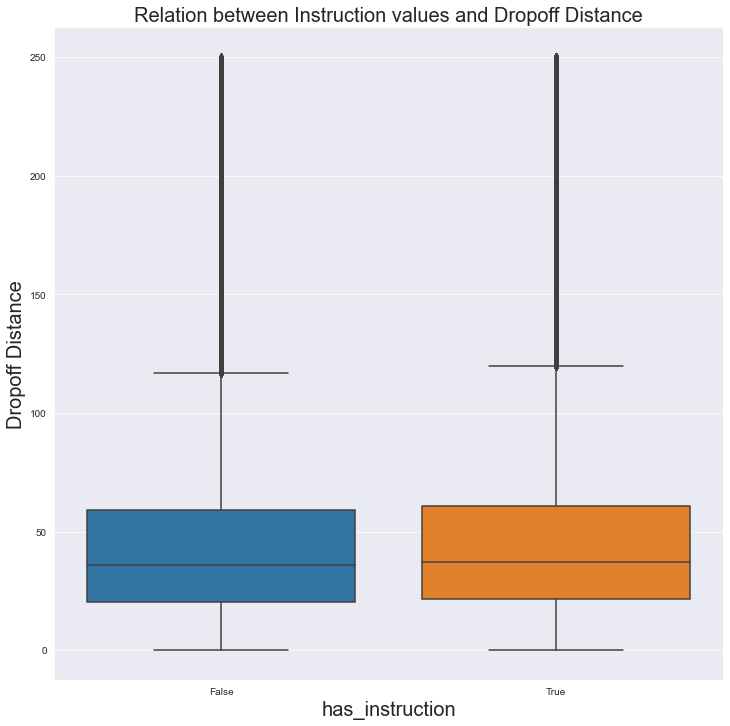

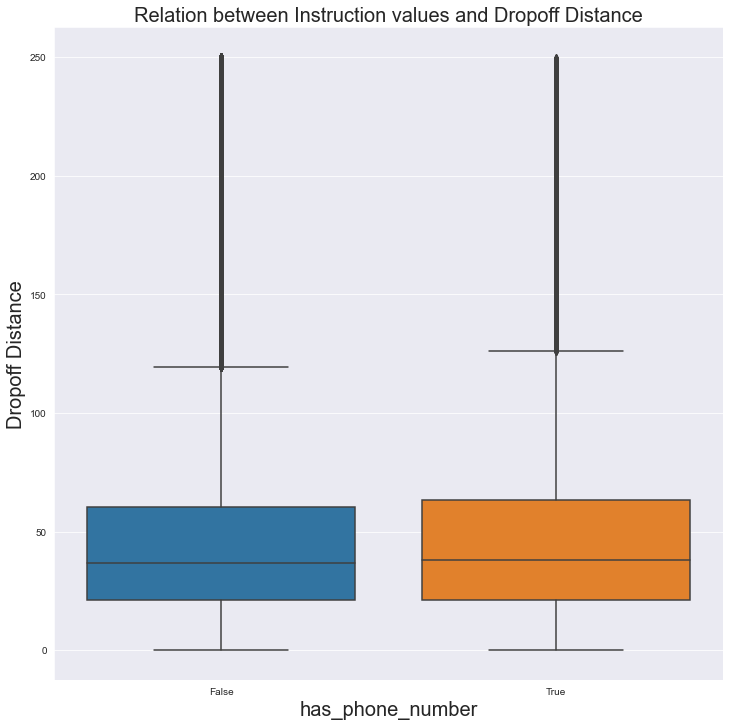

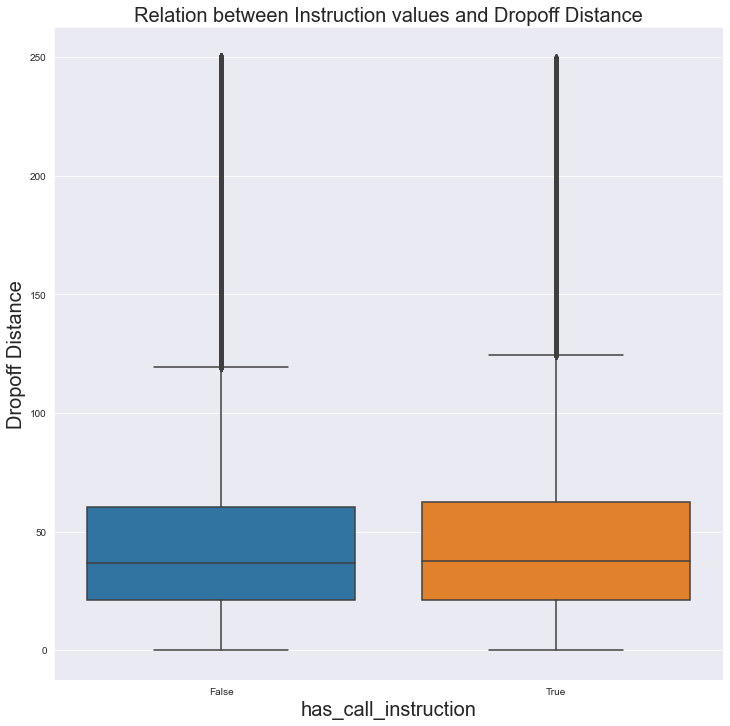

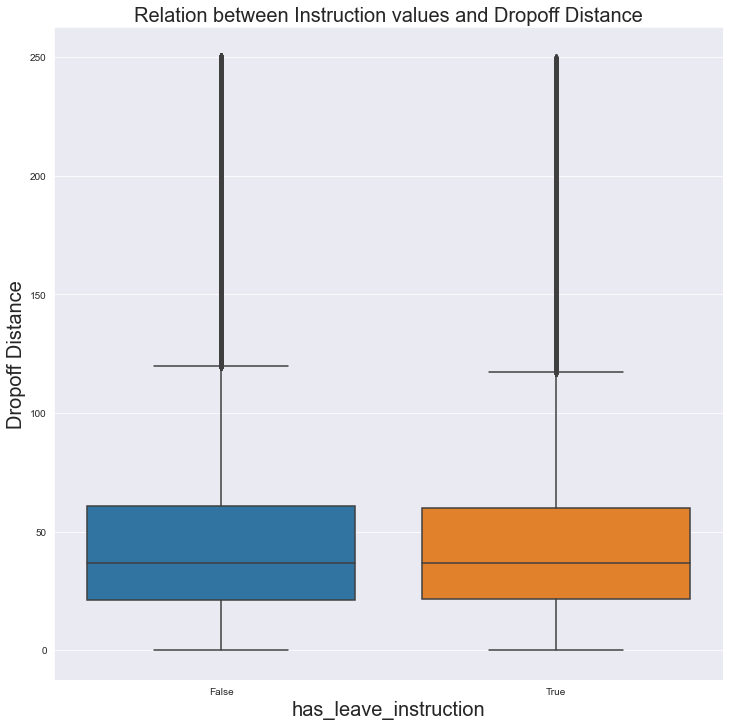

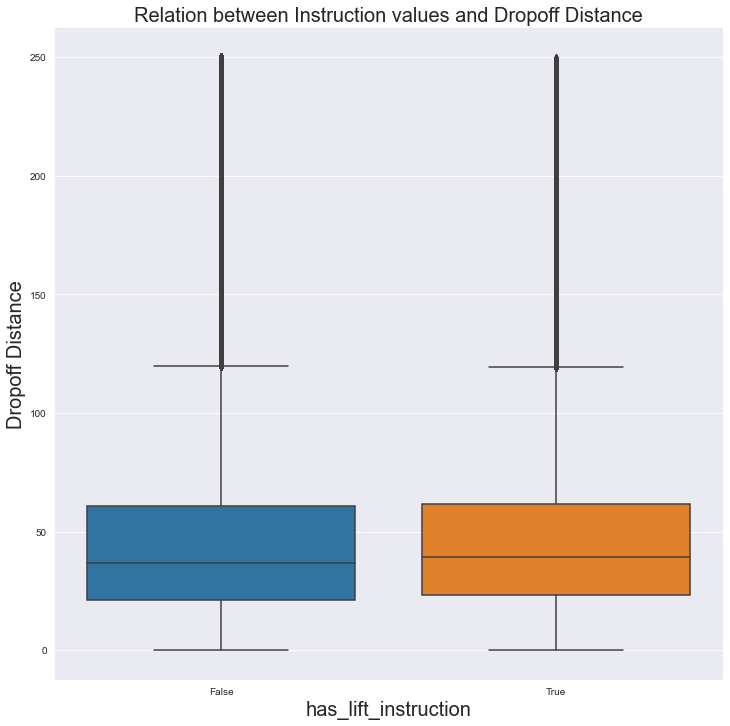

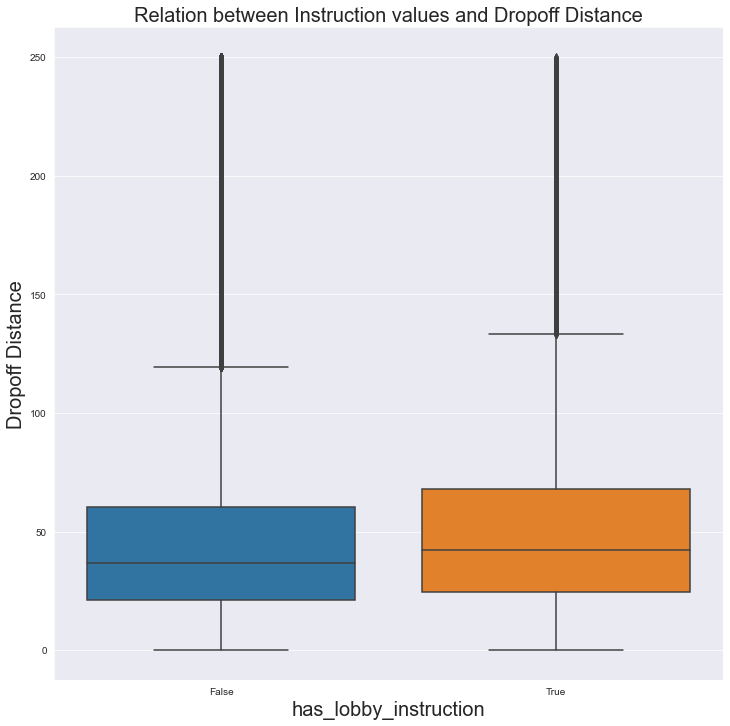

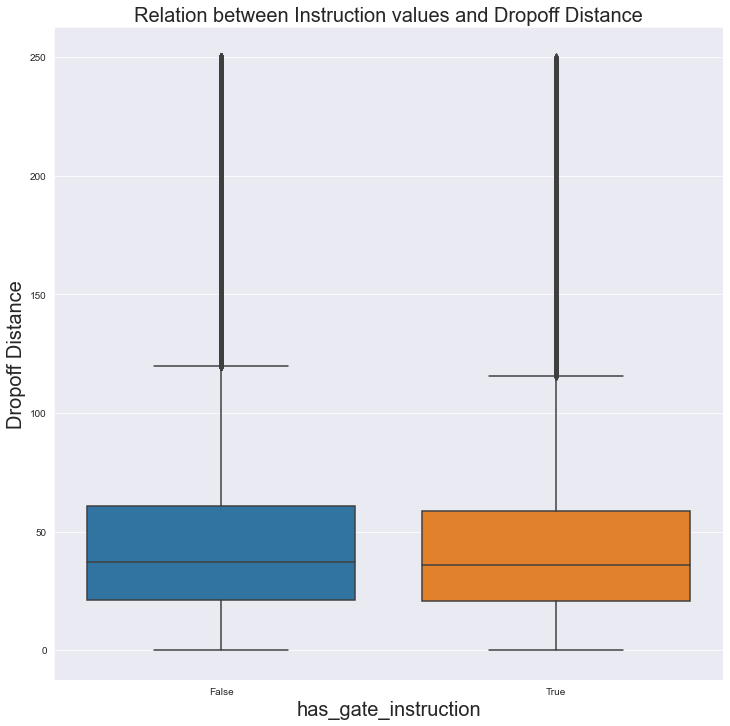

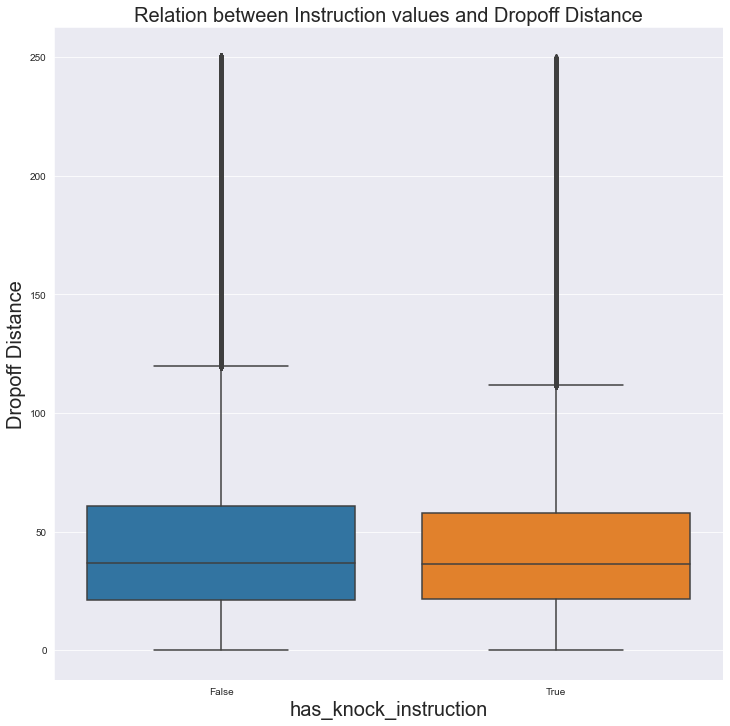

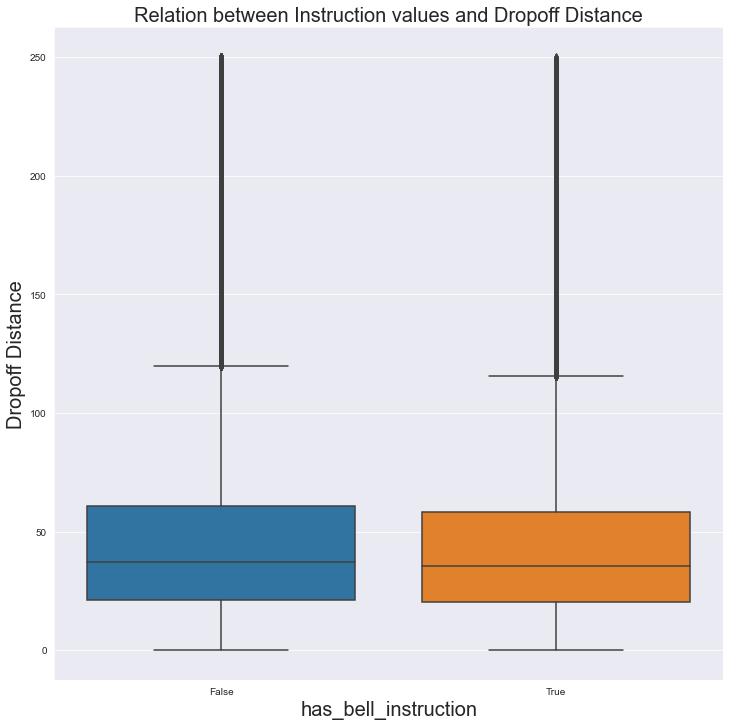

In [76]:
subset = subset[subset['logistics_dropoff_distance'] <= 250]
for instruction in instruction_fields:
    fig, ax = plt.subplots(figsize=(12,12))
    ax = sns.boxplot(x='{0}'.format(instruction), y="logistics_dropoff_distance", data=subset)
    ax.set(xlabel='{0}'.format(instruction), ylabel='Dropoff Distance', title = 'Relation between Instruction values and Dropoff Distance')
#     ax.set_yticks(list(range(0,220,10)))
#     ax.set_yticklabels([int(x) for x in ax.get_yticks()], fontsize=10)
    plt.show()
    

In [51]:
print(subset.columns)

Index(['hour', 'logistics_dropoff_distance'], dtype='object')


Customer ID vs orders

This is just to see whether orders with a frequency of 1 can be contributing to large dropoff distances or not

In [196]:
customers_counts = Counter(df['customer_id'].tolist())
single_orders = {x: count for x, count in customers_counts.items() if count==1}
multiple_orders = {x: count for x, count in customers_counts.items() if count>1}


Total customer ids = 563935 (100%)  
Total ids with single order = 191768 (34%)  
Total ids with multiple order = 372167 (66%)

Let's check the box plot distributions of both

<ipython-input-198-00d83f9a2ace>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["customer_type"] = subset.apply(lambda row: classify_freq(row['customer_id'], single_orders, multiple_orders), axis=1)


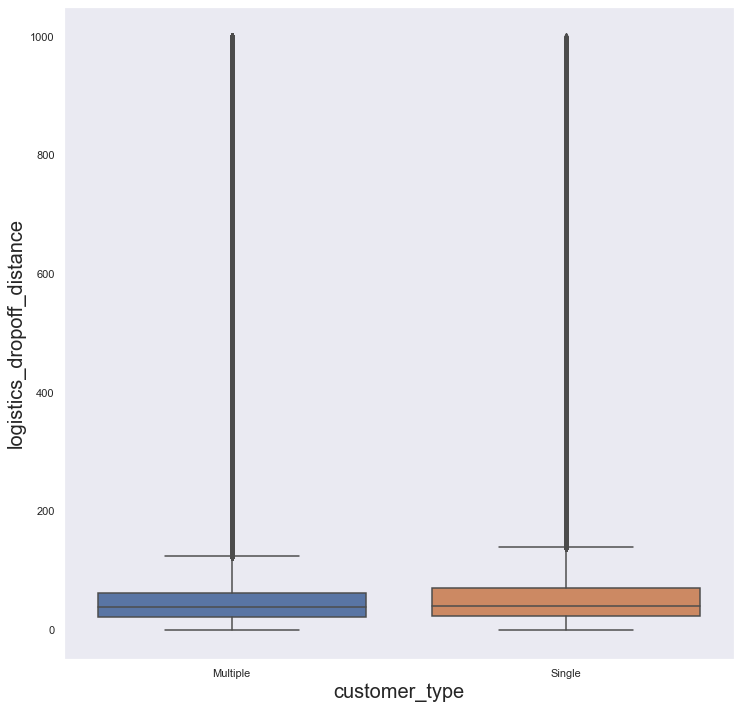

In [198]:
subset = df[['customer_id', 'logistics_dropoff_distance']]

def classify_freq(customer_id, single_orders,multiple_orders):
    if customer_id in single_orders:
        return "Single"
    elif customer_id in multiple_orders:
        return "Multiple"
    
    else:
        return "None"
    
subset["customer_type"] = subset.apply(lambda row: classify_freq(row['customer_id'], single_orders, multiple_orders), axis=1)
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.boxplot(x="customer_type", y="logistics_dropoff_distance", data=subset)

It can be seen that single orders might slightly lead to a higher dropoff distance, this could be because of first time users. Though this doesn't imply that single orders are always first time users but a wider distribution might help us add an additional delivery time to account for inaccuracies

In [202]:
df.to_csv('file_for_training.csv', index=False)

## Conclusion

The variables and their individual effects were analysed. From what can be seen  
a. The continuous variables are useful i.e. Order Item Counts and Order Value  
b. Time (from an hour's perspective wasn't useful), though we do notice some peaks during certain hours.Days of the week, days of month can also be analysed but were skipped to keep the model simple.  
c. Geohash helped us extract a few features and opened the possibility of further analysis to create many more granular features accordingly. Geohash8 was too precise, using a much more generic has like geohash5 with 37 levels or geohash6 with 622 levels (then n clusters to group similar ones) can be done.  
d. Instructions are mostly false and are highly correlated because of the value of False occuring together. But analysing the means of each of the True and False revealed a difference of 20m on an average. So they will form a part of the predictive model and will be considered.